# Additional Examples for Analysis of Soma, Synapse, and Neuroglancer

Please see the other example notebook to get up to speed! We're going to start by importing the same modules and files as before.

In [27]:
import pandas as pd
import numpy as np
from nglui import statebuilder

soma_table_file = '../data/soma_valence_v185.csv'
soma_df = pd.read_csv(soma_table_file)

# Load the synapse table into pandas
synapse_table_file = '../data/pni_synapses_v185.csv'
synapse_df = pd.read_csv(synapse_table_file)

# Convert pt_position strings to a list:
def position_string_to_array(pos_string):
    vals = pos_string[1:-1].split(' ')
    return [int(x) for x in vals if len(x) > 0]

# "apply" will apply this function to every element of the column
soma_df['pt_position'] = soma_df['pt_position'].apply(position_string_to_array)

### Pulling tables together to do some analysis.
#### What fraction of inhibitory outputs for different cells target soma/proximal dendrite versus more distal dendrite?

Now that we've seen the data and used the tools to look at the Let's finally use these tools to look into a deeper question.

In [28]:
inhibitory_root_ids = soma_df.query('cell_type=="i"')['pt_root_id'].values
inhib_syn_df = synapse_df.query('pre_root_id in @inhibitory_root_ids')

In [29]:
syn_count_df = inhib_syn_df[['pre_root_id', 'cleft_vx']].groupby('pre_root_id').count()
syn_count_df = syn_count_df.rename(columns={'cleft_vx': 'num_pre'})

In [30]:
syn_count_df.query('num_pre > 100')

,num_pre
pre_root_id,
648518346349515986,133
648518346349525188,122
648518346349528994,1082
648518346349538179,516
648518346349538285,183
648518346349538638,150
648518346349538791,386
648518346349539215,1475
648518346349539846,761


In [31]:
high_output_inhibitory_root_ids = syn_count_df.query('num_pre > 100').index

In [32]:
inhib_syn_soma_df = inhib_syn_df.merge(soma_df[['pt_root_id', 'pt_position']], left_on='post_root_id', right_on='pt_root_id', how='inner')

Now we need to define a function that maps each synapse data row into the distance between the synapse and the soma center point.

In [33]:
def synapse_dist_from_soma(row):
    syn_loc = np.array([row['ctr_pt_x_nm'], row['ctr_pt_y_nm'], row['ctr_pt_z_nm']])
    soma_loc = np.array(row['pt_position']) * np.array([4,4,40])
    return np.linalg.norm(syn_loc-soma_loc)

In [34]:
inhib_syn_soma_df['dist_from_soma'] = inhib_syn_soma_df.apply(synapse_dist_from_soma, axis=1)

# Call anything within 10 microns (10,000 nm) as a somatic input.
inhib_syn_soma_df['is_soma_synapse'] = inhib_syn_soma_df['dist_from_soma'] < 10_000
inhib_syn_soma_count = inhib_syn_soma_df.groupby(['pre_root_id', 'is_soma_synapse']).count().loc[high_output_inhibitory_root_ids]

Now let's look at a single cell:

In [35]:
root_id = 648518346349539215
inhib_syn_soma_df.query('pre_root_id == @root_id and is_soma_synapse==True')

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx,pt_root_id,pt_position,dist_from_soma,is_soma_synapse
7,2520721,648518346349539215,648518346349539846,691,247488,231720,55560,61896,57878,1390,61872,57930,1389,61798,57856,1390,648518346349539846,"[60148, 58689, 1298]",8367.897705,True
8,1835025,648518346349539215,648518346349539846,294,248048,232904,55960,62042,58180,1399,62012,58226,1399,61948,58214,1399,648518346349539846,"[60148, 58689, 1298]",8680.059908,True
82,2383018,648518346349539215,648518346349537038,544,309360,239984,14960,77250,59982,375,77340,59996,374,77314,60066,375,648518346349537038,"[77197, 61773, 428]",7450.936049,True
84,2080722,648518346349539215,648518346349537038,372,307040,242128,17200,76728,60494,429,76760,60532,430,76726,60596,429,648518346349537038,"[77197, 61773, 428]",5263.382943,True
115,1600812,648518346349539215,648518346349537649,243,438296,277464,3720,109580,69282,95,109574,69366,93,109516,69342,95,648518346349537649,"[108709, 69490, 195]",5372.524174,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2935906,648518346349539215,648518346349539572,584,302776,234832,59120,75698,58672,1473,75694,58708,1478,75592,58664,1473,648518346349539572,"[73844, 58717, 1468]",7410.890365,True
3182,2979684,648518346349539215,648518346349539572,283,303736,236576,59840,75934,59108,1490,75934,59144,1496,75826,59120,1490,648518346349539572,"[73844, 58717, 1468]",8605.885428,True
3216,232527,648518346349539215,648518346349539803,117,300760,205420,9240,75156,51422,229,75190,51355,231,75218,51354,228,648518346349539803,"[75110, 50367, 120]",5952.672005,True
3253,560035,648518346349539215,648518346349539885,110,457152,217232,51960,114238,54284,1299,114288,54308,1299,114296,54360,1299,648518346349539885,"[115294, 52755, 1198]",8432.266599,True


In [36]:
inhib_syn_soma_df['ctr_position'] = inhib_syn_soma_df.apply(lambda x: [x['ctr_pos_x_vx'], x['ctr_pos_y_vx'], x['ctr_pos_z_vx']], axis=1)

In [39]:
image_path = 'precomputed://gs://microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked'
segmentation_path = 'precomputed://gs://microns_public_datasets/pinky100_v185/seg'

img = statebuilder.ImageLayerConfig(image_path)
seg = statebuilder.SegmentationLayerConfig(segmentation_path, selected_ids_column='pre_root_id')

points = statebuilder.PointMapper('ctr_position', linked_segmentation_column='post_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('soma_synapses', mapping_rules=points, linked_segmentation_layer=seg.name)
sb = statebuilder.StateBuilder([img, seg, anno_layer])

In [40]:
root_id = 648518346349539215
sb.render_state(inhib_syn_soma_df.query('pre_root_id == @root_id and is_soma_synapse == True'), return_as='html')

In [41]:
root_id = 648518346349539215
sb.render_state(inhib_syn_soma_df.query('pre_root_id == @root_id and is_soma_synapse == False'), return_as='html')

### Using Dash to integrate exploratory analysis and statebuilder into interactive plots

Now lets do some analysis that reproduces some results from [Dorkenwald et al. 2019](https://www.biorxiv.org/content/10.1101/2019.12.29.890319v1) as an interactive plot.

The first thing we do is load in the dataframe of synapses between excitatory neurons that was used for that paper.

In [42]:
from jupyter_dash import JupyterDash
from dashdataframe import configure_app
import dash

soma_subgraph_df = pd.read_csv('../data/soma_subgraph_synapses_spines_v185.csv')

As before, we create a column that has x,y,z position as a 3-element point.

In [43]:
soma_subgraph_df['ctr_pos'] = soma_subgraph_df.apply(lambda x: [x.ctr_pos_x_vx,
                                                                x.ctr_pos_y_vx,
                                                                x.ctr_pos_z_vx], axis=1).copy()

We build a statebuilder with layers for the imagery, the segmentation, and an annotation layer that can show synapse locations in this new `ctr_pos` column we created.

In [44]:
img_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://gs://microns_public_datasets/pinky100_v185/seg"

img_layer = statebuilder.ImageLayerConfig(name='img',
                                          source=img_source,
                                          )
seg_layer = statebuilder.SegmentationLayerConfig(name = 'seg',
                                                 source = seg_source)

# setup a mapping rule for point annotations
# in this case this is setup to select pre and post partner
syn_points = statebuilder.PointMapper(point_column='ctr_pos',
                                      set_position=True,
                                      linked_segmentation_column=['pre_root_id', 'post_root_id'])

# add these points linked to the segmentation layer name
syn_layer = statebuilder.AnnotationLayerConfig(name='synapses',
                                               mapping_rules=syn_points,
                                               linked_segmentation_layer=seg_layer.name)

# setup a state builder with this layer pipeline
sb = statebuilder.StateBuilder([img_layer, seg_layer, syn_layer])

Now we are going to set up a plot using Dash that will let us explore the data in this table as scatterplot and automatically create neuroglancer links that highlight selected data points.

To create the neuroglancer link, we need to specify one extra function that takes in a list of selected row index values and a dataframe and returns a neuroglancer link. Since this is exactly what `sb.render_state` does, this is a very simple function:

In [45]:
def visualize_synapses(selected_index, df):
    return sb.render_state(df.loc[selected_index], return_as='url')

In [50]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Configure the app to use this new function to generate links
configure_app(app,
              soma_subgraph_df,              # The dataframe we want to explore
              link_func=visualize_synapses,  # This is the function we just defined
              link_name='Neuroglancer Link',
              plot_columns = ['cleft_vx', 'spine_vol_um3', 'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm'])

# If you're running in a notebook and not jupyterlab, set mode to `inline` or omit the argument entirely.
app.run_server(mode='jupyterlab')

# One great thing about using Dash for this is that you can use the lasso tool to select points and then click "Neuroglancer Link" at the bottom of the app to go to a custom neuroglancer state.

### Multi Synapse Connections

Dorkenwald et al. 2019 focuses on a set of multisynaptic connections, where a presynaptic neuron places more than one synapse onto the postsynaptic neuron.
Spine head size and synapse area are known to correlate with functional strength and thus likely to be affected by plasticity rules.
Because two synapses in a multisynaptic connection share much of the same history, the paper asks if their properties are correlated.

The analysis was done in units of log-volume, so we add these columns to the dataframe.

In [51]:
soma_subgraph_df['log_spine_vol_um3']=np.log10(soma_subgraph_df.spine_vol_um3)
soma_subgraph_df['log_cleft_vx']=np.log(soma_subgraph_df.cleft_vx)

To group synapses by unique pre- and post-synaptic partner, we can use the `groupby` operation in pandas:

In [52]:
conn_grouped = soma_subgraph_df.groupby(['pre_root_id', 'post_root_id'])

We compute the average size of synapses in connection (both log and linear).
The `transform` operation will save it back to each synapse, so the info is repeated for every synapse in a connection.


In [53]:
mean_size_df = conn_grouped[['cleft_vx',
                             'log_spine_vol_um3',
                             'log_cleft_vx',
                             'spine_vol_um3']].transform('mean')

# Rename the columns to be accurate
mean_size_df.columns=['mean_cleft_vx', 
                      'mean_log_spine_vol_um3', 
                      'mean_log_cleft_vx',
                      'mean_spine_vol_um3']

To get the number of synapse in a connection, we can do the same transform operation, but counting instead of taking the mean.

In [54]:
# Using 'cleft_vx' as an arbitrary column. We are justu counting, so the data in the column doesn't matter.
count_df = conn_grouped['cleft_vx'].transform('count')

# Rename the column 
count_df.name = 'num_syn_in_conn'

Because we used `transform`, all of the indices of each synapse are maintained and we can just concatenate these dataframes to add all the columns together.

In [55]:
new_synapse_df = pd.concat([soma_subgraph_df, mean_size_df, count_df], axis=1)

#### Visualizing

Let's start looking at the contents of this analysis.
Pandas comes with simple plotting options to get a glimpse of the data, but then we can turn back to dash dataframes to get a better picture.

For example, this is a histogram of spine volume sizes from single-synapse connections (blue) and from dual synapse connections (orange).

Text(0.5, 1.0, 'see Figure 3d')

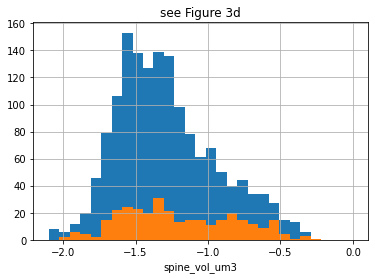

In [56]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
new_synapse_df.query('num_syn_in_conn==1')['log_spine_vol_um3'].hist(bins=np.linspace(-2.1,0,30))
new_synapse_df.query('num_syn_in_conn==2')['log_spine_vol_um3'].hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('spine_vol_um3')
ax.set_title('see Figure 3d')

Interestingly, it looks like the relative amount of smaller and larger spine heads is different between the two.

Does a dual synapse connection tend to have synapses that are either both small or both large?
To get a hint at this, we can plot the mean size within the connection, not just the size for each synapse.


Text(0.5, 1.0, 'see Figure 3e')

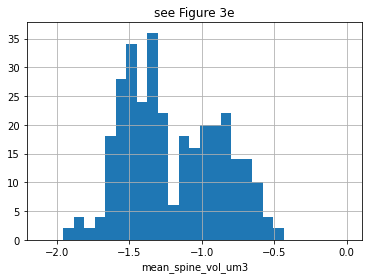

In [57]:
f, ax = plt.subplots()
new_synapse_df.query('num_syn_in_conn==2')['mean_log_spine_vol_um3'].hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('mean_spine_vol_um3')
ax.set_title('see Figure 3e')

You can see below that the results look interestingly bimodal, suggesting that there might be distinct characteristic sizes for synapses between layer 2/3 excitatory neurons: "large spines" and "small spines". See the preprint above for more analysis on this.

Finally, we can go back to JupyterDash to look at the table more dynamically.

In [58]:
selected_columns = ['num_syn_in_conn', 'mean_spine_vol_um3', 'cleft_vx', 'spine_vol_um3',
       'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm', 'log_spine_vol_um3', 'log_cleft_vx',
       'mean_cleft_vx', 'mean_log_spine_vol_um3', 'mean_log_cleft_vx']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

configure_app(app, new_synapse_df,
              link_func=visualize_synapses, link_name='Neuroglancer Link',
              plot_columns = selected_columns)

app.run_server(mode='jupyterlab')